# Unsupervised Learning - Autoencoders
by [David Ohm](http://ohmdsp.github.io/)
/ [GitHub](https://github.com/ohmdsp)

In this notebook, we will explore some neural networks for unsupervised learning. This will give us some tools to explore data in some very interesting ways.

Machine learning with deep neural networks can be classified into two categories:  (1) Unsupervised Learning - You have a lot of data and you want to learn something about the data (e.g., patterns, clustering, reduce dimensionality, generating new data, etc.), and (2) Supervised Learning - You know what you want to learn using your data and you have labeled training data.  We are going to explore the autoencoder.

## Autoencoders

![Autoencoder](images/autoencoder.png)

An autoencoder is a type of neural network that learns to encode a lower dimension representation of its input data.  It can also reproduce the original input data using a decoding process. An autoencoder does not require "labels" to learn.  Instead, it tries to generate an output that is the same as the input. For example, if an image is input, the output from the decoder will be the same image. In this notebook, we will see why this is interesting. 

It is worth mentioning two interesting practical applications of autoencoders: (1)data denoising, and (2)dimensionality reduction for data visualization. In many cases, autoencoders can learn data projections that are more interesting than PCA or other basic techniques.

In [1]:
# imports
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
# Some additional libraries to produce some visualizations for training
from PIL import Image
from libs.utils import montage
plt.style.use('ggplot')

import keras
from keras import layers
from keras.layers import Activation, Dense, Input, Lambda, Layer
from keras.layers import Conv2D, Flatten, MaxPooling2D, UpSampling2D
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.utils import plot_model
from keras.losses import mse, binary_crossentropy
from keras import backend as K
from keras import metrics

In [2]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

Let's load in some MNIST data to use for examples.

In [3]:
from keras.datasets import mnist

In [4]:
(x_train, _), (x_test, _) = mnist.load_data()

In [5]:
print(x_train.shape)

(60000, 28, 28)


In [6]:
# Select 1000 images from the training set for dispay
images = x_train[0:1000]

In [7]:
# Let's take a look at one of these images
img = x_train[0]

In [8]:
img.shape

(28, 28)

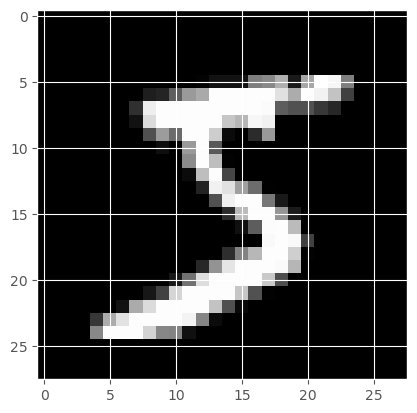

In [9]:
plt.imshow(img, cmap='gray')

Now, we can display a montage of the 1000 images from this training dataset.

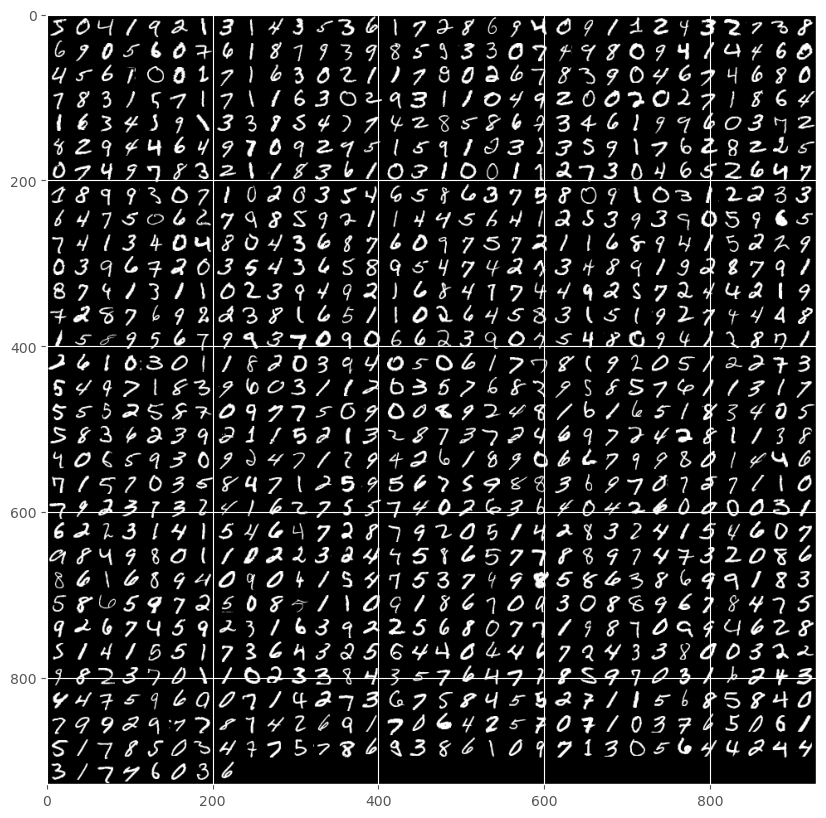

In [10]:
plt.rcParams["figure.figsize"] = (14,10)   # set plot sizes
# Then create a montage and draw the montage
plt.imshow(montage(images), cmap='gray')

Like we did in the preprocessing notebook, let's take a look at the mean of 1000 images from this dataset.

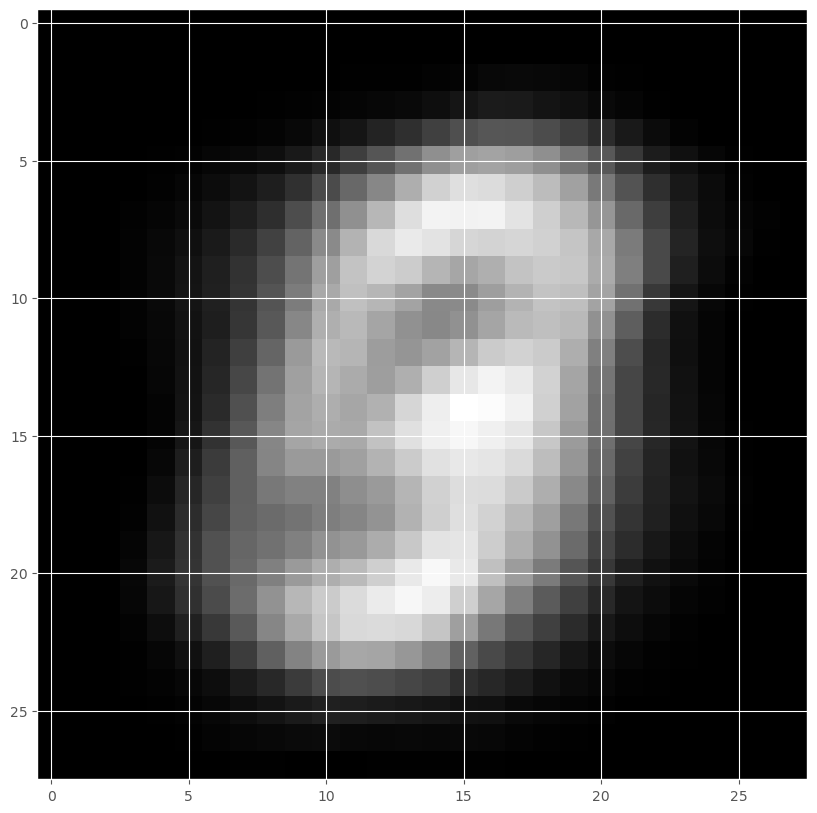

In [11]:
# Take the mean across all 1000 images
mean_img = np.mean(images, axis=0)

# Then plot the mean image.
plt.figure()
plt.imshow(mean_img.reshape((28, 28)), cmap='gray')


## Simple Autoencoder  - Fully Connected Model

We will start with the most basic autoencoder using a fully connected model.  From the original 784 (i.e., 28x28) neurons, we're going to reduce the image dimensions.

In [12]:
#Define the dimension to reduce the original image(s) to
encoding_dim = 32

In [13]:
# placeholder for input
input_img = keras.Input(shape = (784,))

In [14]:
# create autoencoder model
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
decoded = layers.Dense(784, activation='sigmoid')(encoded)
autoencoder = keras.Model(input_img, decoded) 

In [15]:
# make seperate encoder model
encoder = keras.Model(input_img, encoded)

In [16]:
encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 32)                25120     
                                                                 
Total params: 25,120
Trainable params: 25,120
Non-trainable params: 0
_________________________________________________________________


In [17]:
# configure the autoencoder model to use per-pixel crossentropy loss and an optimizer
autoencoder.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0), loss='binary_crossentropy')
#autoencoder.compile(optimizer=tf.keras.optimizers.Adam(lr=.001), loss='binary_crossentropy',metrics=['accuracy'])

In [18]:
# Create the data for training
x_train = x_train.astype('float32') / 255    # normalize images
x_test = x_test.astype('float32') / 255
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))       #flatten images to 1D
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [19]:
# Run the autoencoder training
history = autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 38us/sample - loss: 0.3611 - val_loss: 0.2714
Epoch 2/50
20480/60000 [=========>....................] - ETA: 0s - loss: 0.2700

c:\Users\ohmds\anaconda3\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


60000/60000 [==============================] - 0s 5us/sample - loss: 0.2640 - val_loss: 0.2528
Epoch 3/50
60000/60000 [==============================] - 0s 5us/sample - loss: 0.2429 - val_loss: 0.2311
Epoch 4/50
60000/60000 [==============================] - 0s 6us/sample - loss: 0.2239 - val_loss: 0.2141
Epoch 5/50
60000/60000 [==============================] - 0s 5us/sample - loss: 0.2089 - val_loss: 0.2009
Epoch 6/50
60000/60000 [==============================] - 0s 5us/sample - loss: 0.1973 - val_loss: 0.1909
Epoch 7/50
60000/60000 [==============================] - 0s 5us/sample - loss: 0.1884 - val_loss: 0.1831
Epoch 8/50
60000/60000 [==============================] - 0s 5us/sample - loss: 0.1814 - val_loss: 0.1770
Epoch 9/50
60000/60000 [==============================] - 0s 5us/sample - loss: 0.1757 - val_loss: 0.1717
Epoch 10/50
60000/60000 [==============================] - 0s 5us/sample - loss: 0.1709 - val_loss: 0.1673
Epoch 11/50
60000/60000 [==============================]

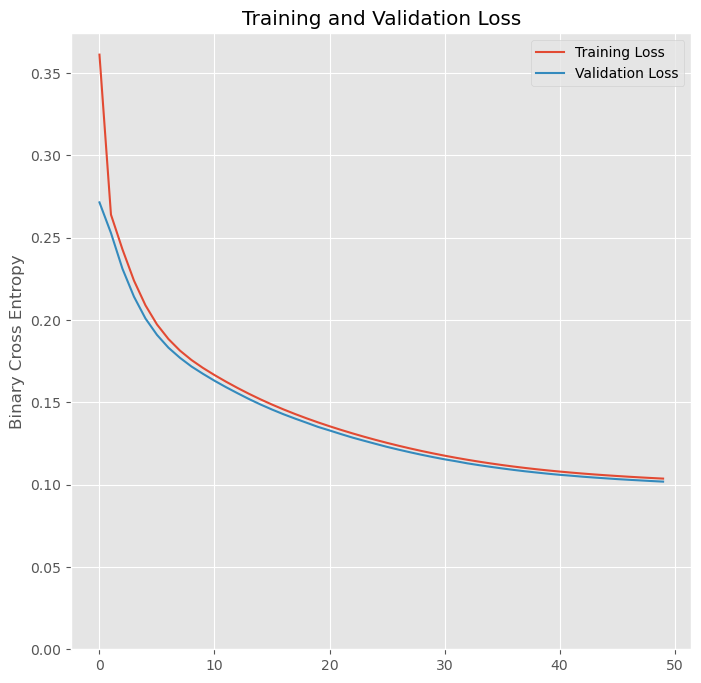

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [21]:
# Create seperate decoder model
# create a placeholder for an encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

In [22]:
#encode and decode some digits. Note: we use images from the test dataset
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
#encoder_imgs = encoder.predict(x_test)

c:\Users\ohmds\anaconda3\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [23]:
print(decoded_imgs.shape)

(10000, 784)


In [24]:
decoded_imgs.mean()

0.13279618

Let's compare some input images to their output images from the autoencoder. You will see that the image reconstruction is not very good. 

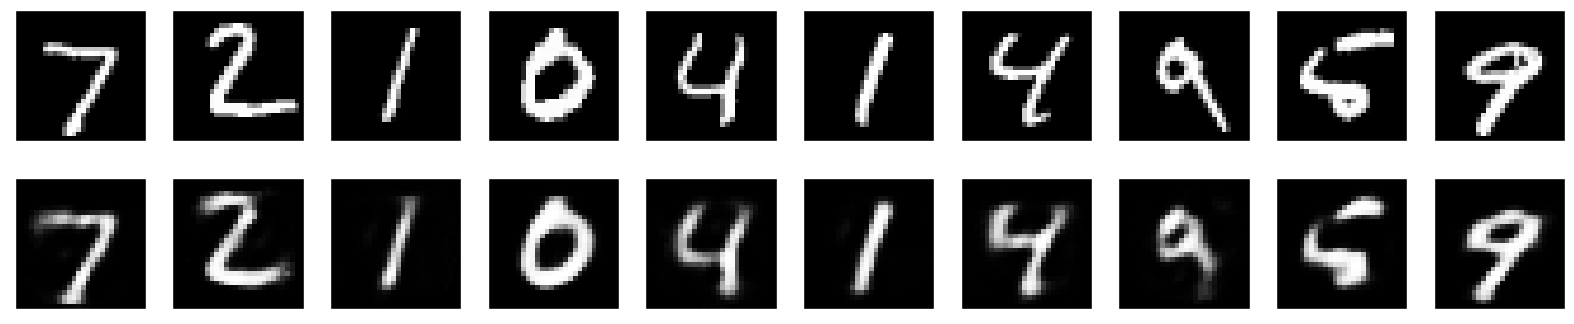

In [25]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

So far, the latent representations of our input images have been constrained by the size of the hidden layer of 32. With a simple neural network like this, the hidden layer is learning an approximation of PCA (principal component analysis). 

Another way we can  constrain the representations to be small (e.g., compressed) is to add a sparsity contraint on the activation function of the hidden layer, so fewer neurons will "fire" each computation. In Keras, this can be done by adding an activity_regularizer to our Dense layer (see next cell). We will not explore this here, but you can experiment on your own.

In [26]:
# add a Dense layer with a L1 activity regularizer
#encoded = Dense(encoding_dim, activation='relu',
#                activity_regularizer=regularizers.l1(10e-5))(input_img)

## Deep Autonencoder

We are not limited to a single layer in the encoder. We could add a stack of layers - making the network deeper.

In [27]:
#clear the previous model
tf.compat.v1.reset_default_graph()

In [28]:
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

In [29]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=tf.keras.optimizers.Adadelta(lr=1.0), loss='binary_crossentropy')

autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 64)                2112      
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 784)               101136

c:\Users\ohmds\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adadelta.py:79: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [30]:
history = autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 1s 11us/sample - loss: 0.3556 - val_loss: 0.2633
Epoch 2/20
60000/60000 [==============================] - 0s 8us/sample - loss: 0.2559 - val_loss: 0.2469
Epoch 3/20
60000/60000 [==============================] - 0s 8us/sample - loss: 0.2400 - val_loss: 0.2310
Epoch 4/20
60000/60000 [==============================] - 0s 8us/sample - loss: 0.2218 - val_loss: 0.2122
Epoch 5/20
60000/60000 [==============================] - 0s 8us/sample - loss: 0.2091 - val_loss: 0.2032
Epoch 6/20
60000/60000 [==============================] - 0s 8us/sample - loss: 0.1975 - val_loss: 0.1927
Epoch 7/20
60000/60000 [==============================] - 0s 8us/sample - loss: 0.1886 - val_loss: 0.1829
Epoch 8/20
60000/60000 [==============================] - 0s 8us/sample - loss: 0.1808 - val_loss: 0.1750
Epoch 9/20
60000/60000 [==============================] - 0s 8us/sample - loss: 0.1736 - val_loss: 0.

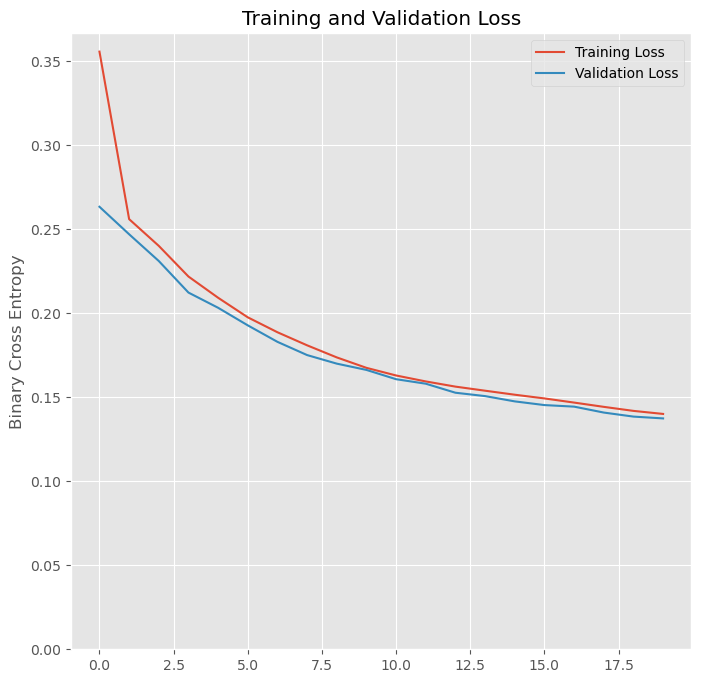

In [31]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [32]:
#encode and decode some digits from test set
decoded_imgs = autoencoder.predict(x_test)

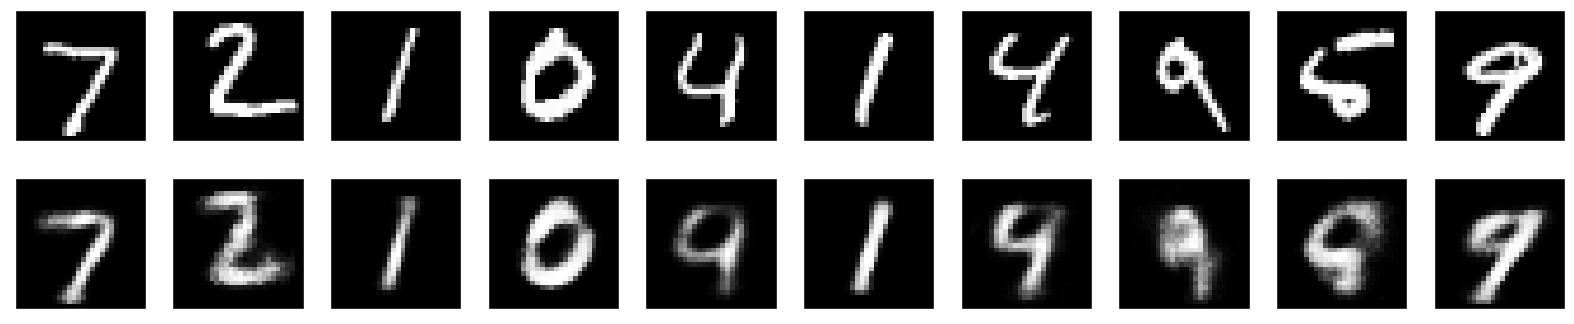

In [33]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

The deeper model looks to generate similar results, but it is not a dramatic improvement over the simple model. Let's look at using convolutional layers.

## Convolutional Autoencoder
Since our inputs are images, it makes sense to use convolutional neural networks as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders -- they simply perform much better.

Let's implement a convolutional autoencoder to see how it performs. The encoder will consist in a stack of Conv2D and MaxPooling2D layers (max pooling being used for spatial down-sampling), while the decoder will consist in a stack of Conv2D and UpSampling2D layers.

In [34]:
#clear the previous model
tf.compat.v1.reset_default_graph()

In [35]:
input_img = Input(shape=(28, 28, 1))

In [36]:
# Define our encoder network
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
# at this point the representation is (4, 4, 8) i.e. 128-dimensional

In [37]:
# Define our decoder network
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

In [38]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=tf.keras.optimizers.Adadelta(lr=1.0), loss='binary_crossentropy')
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 8)           584   

In [39]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [40]:
#from keras.callbacks import TensorBoard

history = autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 4s 60us/sample - loss: 0.2140 - val_loss: 0.1655
Epoch 2/20
60000/60000 [==============================] - 2s 29us/sample - loss: 0.1575 - val_loss: 0.1479
Epoch 3/20
60000/60000 [==============================] - 2s 31us/sample - loss: 0.1440 - val_loss: 0.1344
Epoch 4/20
60000/60000 [==============================] - 2s 31us/sample - loss: 0.1361 - val_loss: 0.1322
Epoch 5/20
60000/60000 [==============================] - 2s 31us/sample - loss: 0.1308 - val_loss: 0.1254
Epoch 6/20
60000/60000 [==============================] - 2s 30us/sample - loss: 0.1265 - val_loss: 0.1254
Epoch 7/20
60000/60000 [==============================] - 2s 30us/sample - loss: 0.1238 - val_loss: 0.1226
Epoch 8/20
60000/60000 [==============================] - 2s 31us/sample - loss: 0.1210 - val_loss: 0.1208
Epoch 9/20
60000/60000 [==============================] - 2s 31us/sample - loss: 0.1191 - val_

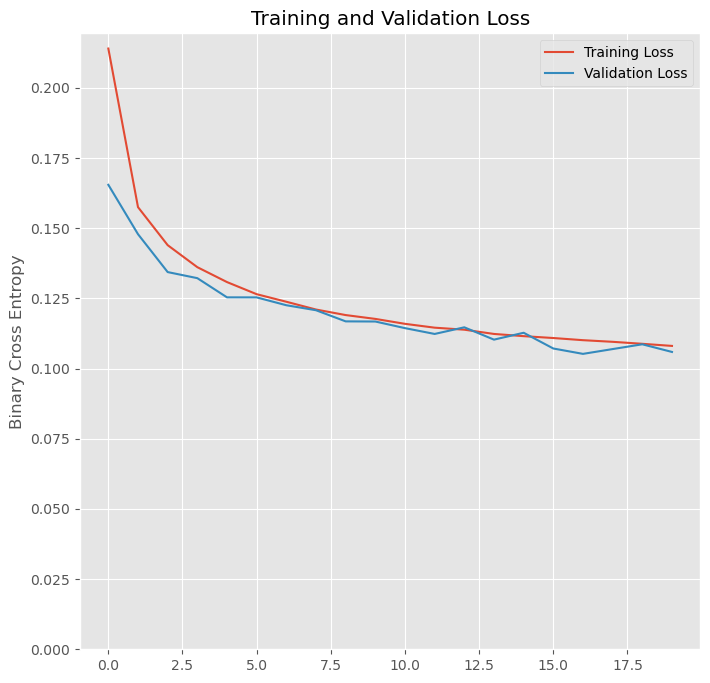

In [41]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [42]:
#encode and decode some digits from test set
decoded_imgs = autoencoder.predict(x_test)

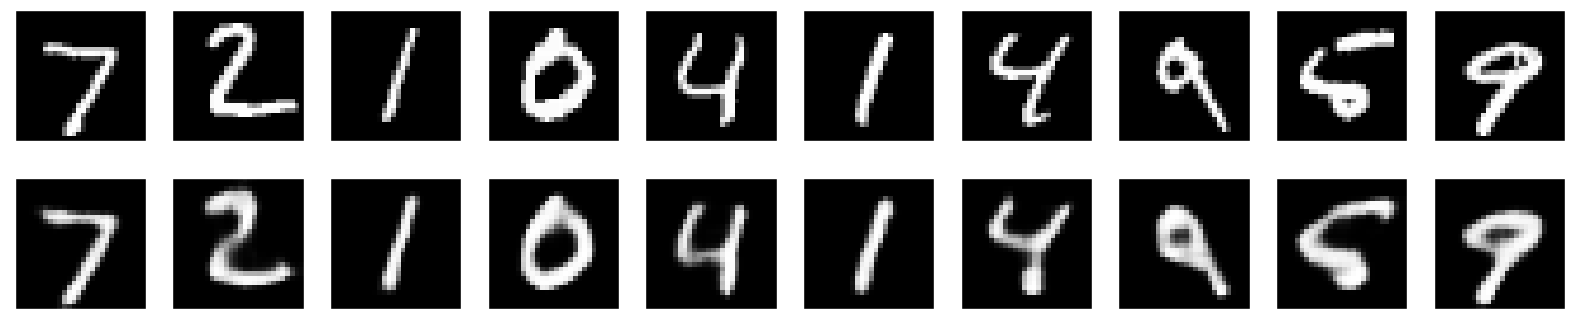

In [43]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

The results from the convolutional autoencoder are better. It is especially apparent with the 9 and 2 digits.

We can also look at the encoded representations. These are shaped as 8x4x4 so we need to reshape them to 4x32 to display.

In [44]:
# create seperate encoder model
encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test)

In [45]:
encoded_imgs[0].shape

(4, 4, 8)

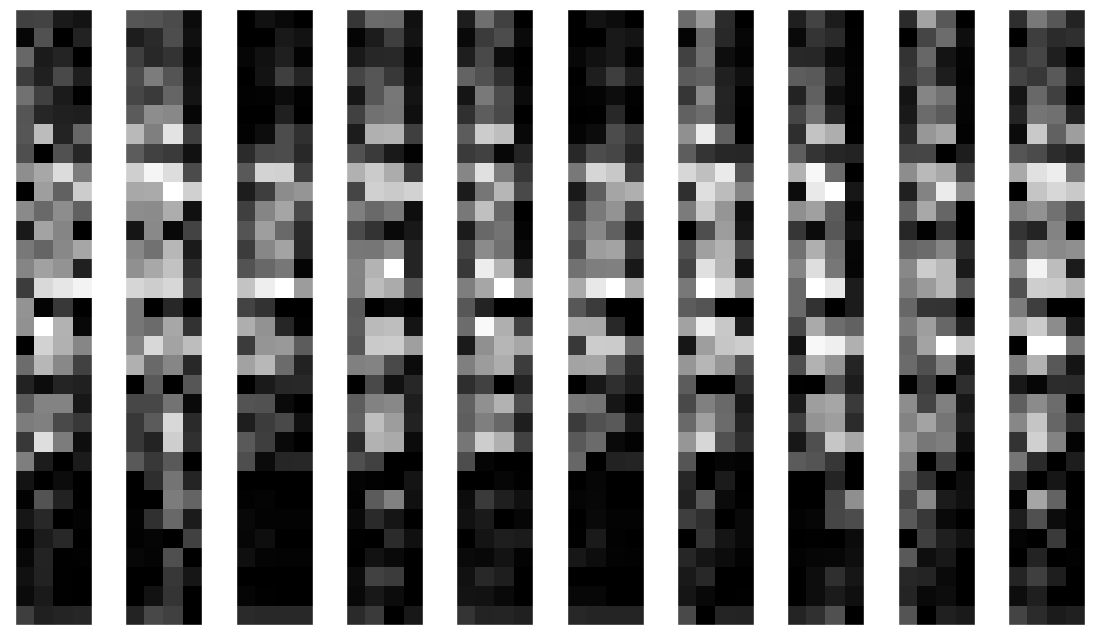

In [46]:
n = 10
plt.figure(figsize=(14, 8))
for i in range(n):
    ax = plt.subplot(1, 10, i+1)
    plt.imshow(encoded_imgs[i].reshape(4, 4 * 8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


## Denoising Autoencoder

The denoising autoencoder is a very simple extension to an autoencoder, and it can be a useful tool in the hands of a signal processing engineer.  We will use an convolutional autoencoder to work on a toy image denoising problem. We will train the autoencoder to map noisy digits images to clean digits images. Note - we will simulate the noisy data by adding noise to images from the MNIST dataset.

In [47]:
#clear the previous model
tf.compat.v1.reset_default_graph()

In [48]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [49]:
# Generate noisy MNIST images by adding noise with normal dist centered at 0.5 and variance of 0.5
noise = np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_train_noisy = x_train + 0.5*noise
noise = np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_test_noisy = x_test + 0.5*noise

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Let's look at some of the noisy digits:

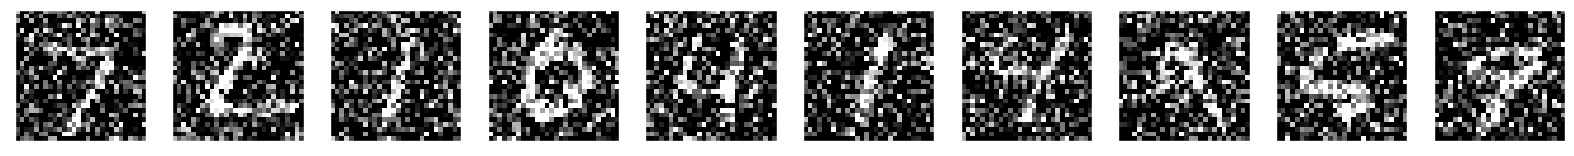

In [50]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

We will use a slightly different model for denoising that has more filters per layer.

In [51]:
input_img = Input(shape=(28, 28, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

In [52]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=tf.keras.optimizers.Adadelta(lr=1.0), loss='binary_crossentropy')

In [53]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 32)          9248  

In [54]:
history = autoencoder.fit(x_train_noisy, x_train,
                epochs=25,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 3s 44us/sample - loss: 0.1748 - val_loss: 0.1202
Epoch 2/25
60000/60000 [==============================] - 2s 36us/sample - loss: 0.1177 - val_loss: 0.1119
Epoch 3/25
60000/60000 [==============================] - 2s 37us/sample - loss: 0.1106 - val_loss: 0.1099
Epoch 4/25
60000/60000 [==============================] - 2s 37us/sample - loss: 0.1071 - val_loss: 0.1039
Epoch 5/25
60000/60000 [==============================] - 2s 37us/sample - loss: 0.1048 - val_loss: 0.1025
Epoch 6/25
60000/60000 [==============================] - 2s 37us/sample - loss: 0.1031 - val_loss: 0.1030
Epoch 7/25
60000/60000 [==============================] - 2s 37us/sample - loss: 0.1023 - val_loss: 0.1016
Epoch 8/25
60000/60000 [==============================] - 2s 36us/sample - loss: 0.1015 - val_loss: 0.1010
Epoch 9/25
60000/60000 [==============================] - 2s 37us/sample - loss: 0.1008 - val_

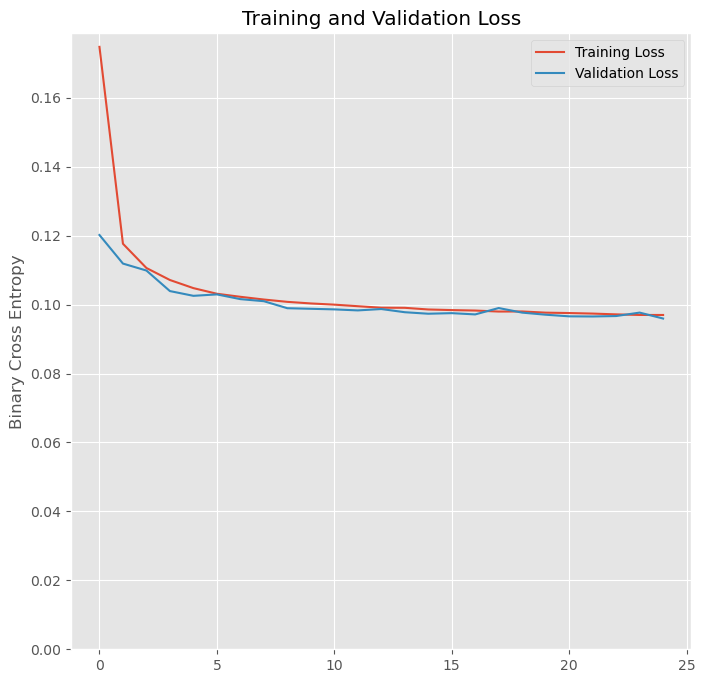

In [55]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [56]:
# Predict the Autoencoder output from corrupted test images
decoded_imgs = autoencoder.predict(x_test_noisy)

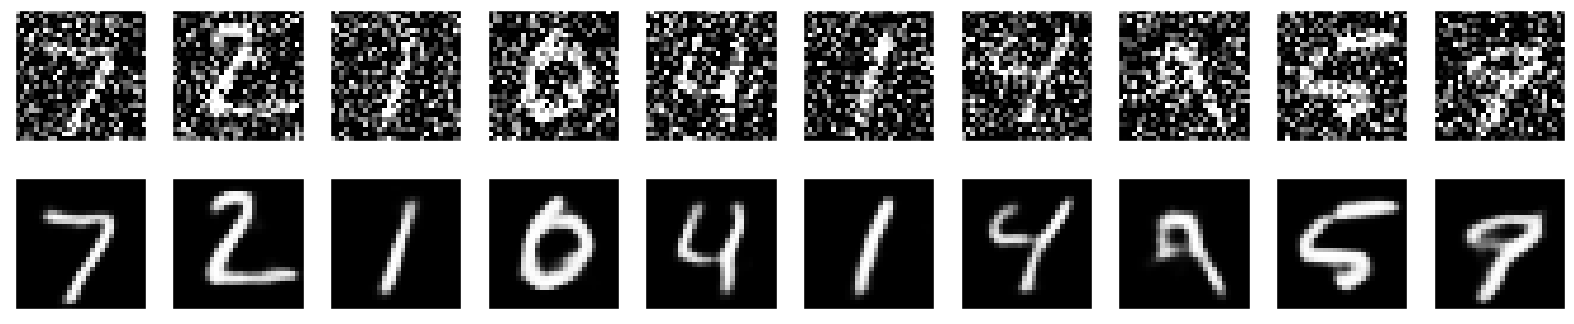

In [57]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Variational Autoencoder (VAE)

A variational autoencoder is a type of autoencoder with constraints on the encoded representations that can be learned. It learns a latent variable model for the input data. So, instead of letting your neural network learn an arbitrary function, you are learning the parameters of a probability distribution for modeling your data. If you sample points from this distribution, you can generate new input data samples. For this reason a VAE is considered a "generative model".

How does a variational autoencoder work?

First, an encoder network turns the input samples x into two parameters in a latent space, which we will note z_mean and z_log_sigma (i.e., the mean and log of variance for a normal distribution). Then, we randomly sample points z from that latent normal distribution, using z = z_mean + exp(z_log_sigma) * epsilon, where epsilon is a random normal distribution. Finally, a decoder network maps these latent space points back to the original input data.

The parameters of the nearal network are trained via two loss functions: a reconstruction loss forcing the decoded samples to match the initial inputs (just like in our previous autoencoders), and the KL divergence between the learned latent distribution and the prior distribution, acting as a regularization term. It is not required to use the KL term, although it helps in learning well-formed latent spaces and reducing overfitting to the training data.

Let's make one!

In [58]:
#clear the previous model
tf.compat.v1.reset_default_graph()

In [59]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [60]:
x_train.shape

(60000, 784)

In [61]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [62]:
# VAE model = encoder + decoder
input_shape = (original_dim, )
latent_dim = 2
intermediate_dim = 512
batch_size = 100
epochs = 50

x = keras.Input(shape = (original_dim,))
h = layers.Dense(intermediate_dim, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(h)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(h)
z = Sampling()([z_mean, z_log_var])

decoder_h = layers.Dense(intermediate_dim, activation="relu")
decoder_mean = layers.Dense(original_dim, activation="sigmoid")
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

#vae_encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
#vae_encoder.summary()

In [63]:
# Custom Loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)
    
    def vae_loss(self, x, x_decoded_mean):
        xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs = inputs)
        return x        

In [64]:
y = CustomVariationalLayer()([x, x_decoded_mean])
vae = keras.Model(x, y)
vae.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=.001), loss = None)
vae.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 512)          401920      ['input_1[0][0]']                
                                                                                                  
 z_mean (Dense)                 (None, 2)            1026        ['dense[0][0]']                  
                                                                                                  
 z_log_var (Dense)              (None, 2)            1026        ['dense[0][0]']                  
                                                                                              

### We can create an anomoly
For fun and exploration, let's remove a digit from the dataset to simulate an anomoly. We can explore methods for anomoly detection later.

In [66]:
anomalous_digit = 8

In [67]:
# remove anomalous digit from train data
train_mask = np.where(y_train!=anomalous_digit)[0]
x_train = x_train[train_mask, :]
y_train = y_train[train_mask]

# create binary labels
test_mask = np.where(y_test != anomalous_digit)[0]
y_test_binary = np.zeros(y_test.shape[0])
y_test_binary[test_mask] = 1

In [68]:
history = vae.fit(x_train,
        shuffle=True,
        epochs=10,
        batch_size=100)

Train on 54149 samples
Epoch 1/10
54149/54149 [==============================] - 1s 27us/sample - loss: 185.6124
Epoch 2/10
54149/54149 [==============================] - 1s 20us/sample - loss: 167.4979
Epoch 3/10
54149/54149 [==============================] - 1s 20us/sample - loss: 164.0969
Epoch 4/10
54149/54149 [==============================] - 1s 20us/sample - loss: 161.5017
Epoch 5/10
54149/54149 [==============================] - 1s 20us/sample - loss: 159.2567
Epoch 6/10
54149/54149 [==============================] - 1s 21us/sample - loss: 157.3679
Epoch 7/10
54149/54149 [==============================] - 1s 20us/sample - loss: 155.9645
Epoch 8/10
54149/54149 [==============================] - 1s 20us/sample - loss: 154.8251
Epoch 9/10
54149/54149 [==============================] - 1s 20us/sample - loss: 154.0082
Epoch 10/10
54149/54149 [==============================] - 1s 21us/sample - loss: 153.2808


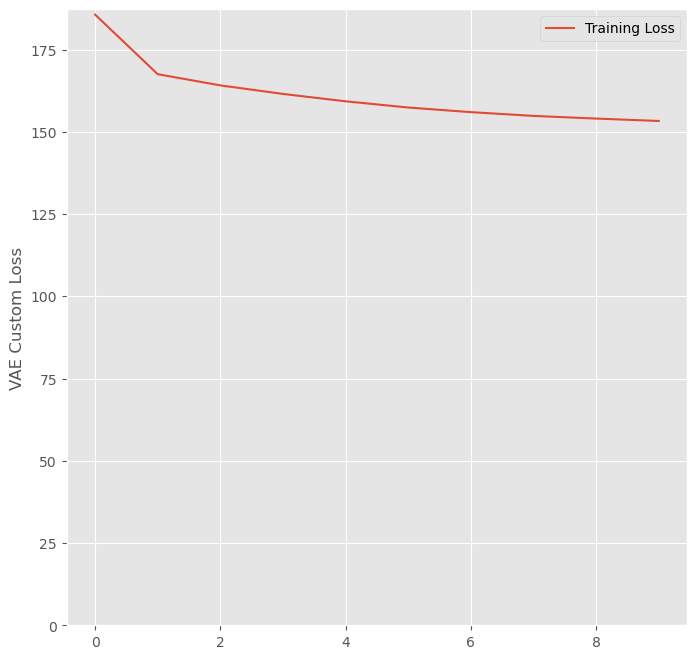

In [69]:
loss = history.history['loss']
#val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.plot(loss, label='Training Loss')
#plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('VAE Custom Loss')
plt.ylim([0,max(plt.ylim())])
#plt.title('Training and Validation Loss')
plt.show()

## Visualize the Learned Latent Distribution

A variational autoencoder allows us to inspect the latent space to learn more about our model and our data.  For example, in anomaly detection, latent variables can be used to try and determine the cause of anomalies.  
In the case that we have 2 latent dimensions we can easily visualize the representation.  With higher dimensionality we can use dimensionality reducing techniques such as PCA or t-SNE to visualize.

In [70]:
# build a model to project inputs on to the latent space
encoder = Model(x, z_mean)

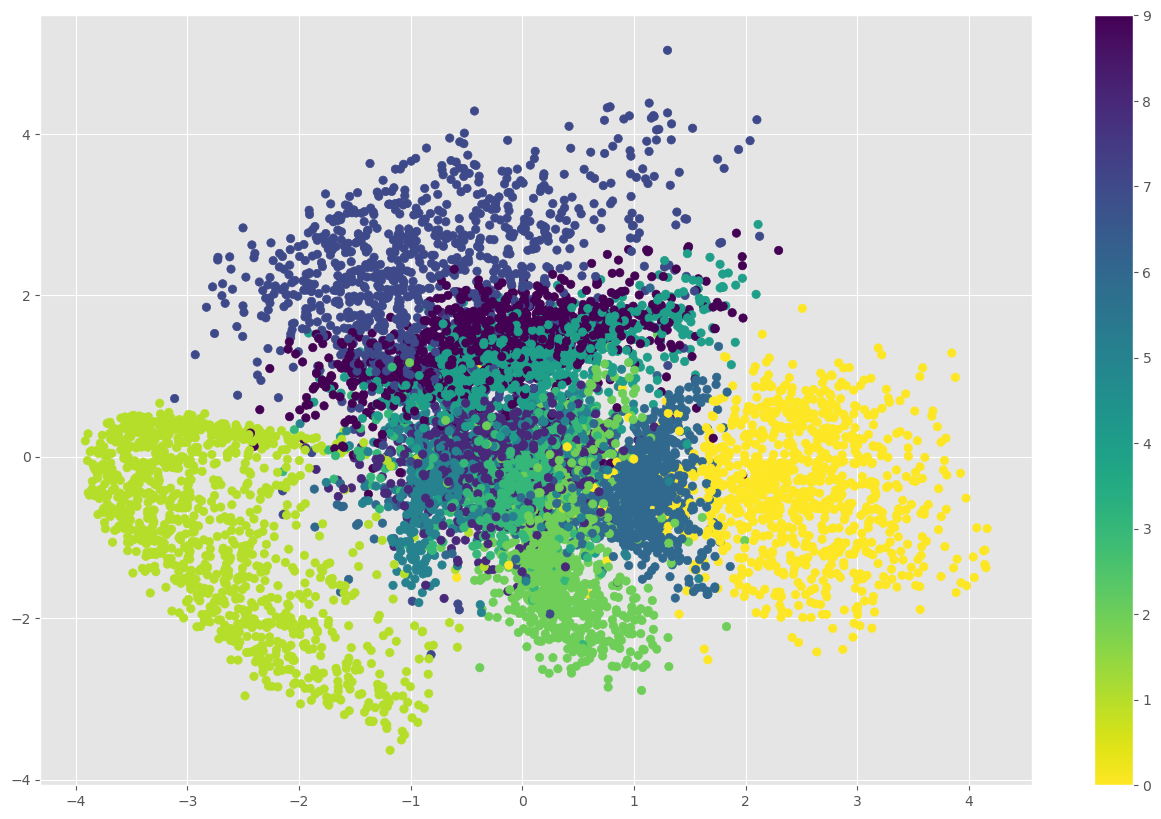

In [71]:
if latent_dim == 2:
    # display a 2D plot of the digit classes in the latent space
    x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
    plt.figure(figsize=(16, 10))
    plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='viridis_r')
    plt.colorbar()
    plt.show()

In [73]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)
generator.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 512)               1536      
                                                                 
 dense_2 (Dense)             (None, 784)               402192    
                                                                 
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


c:\Users\ohmds\anaconda3\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


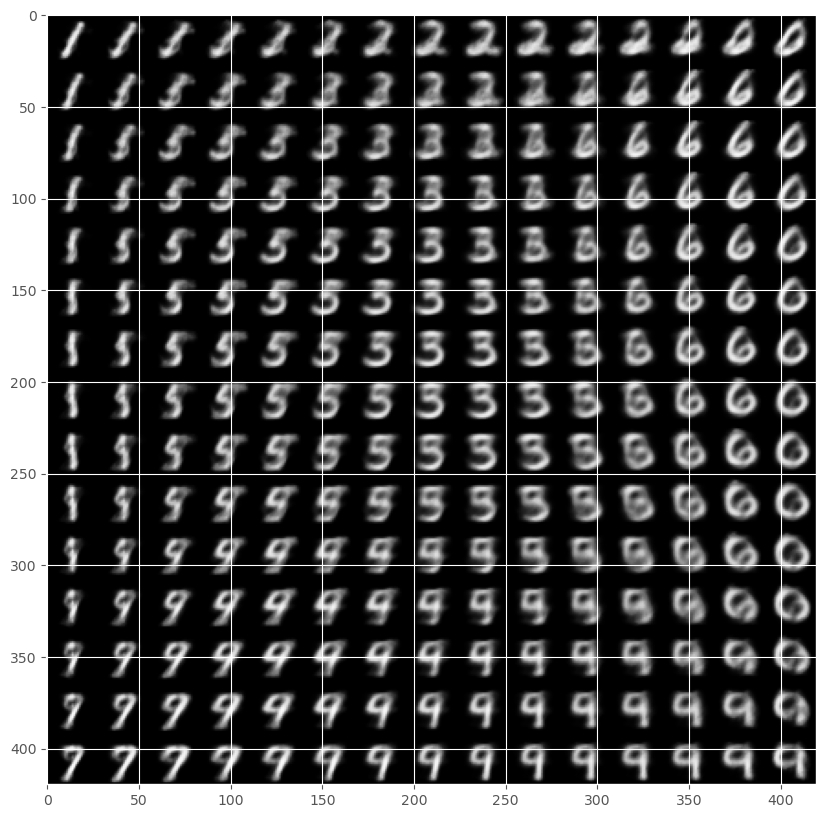

In [74]:
# display a 2D manifold of the digits
from scipy.stats import norm
epsilon_std = 1
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit       
        
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

## Anomaly Detection

We detect anomalies by computing the probability that our reconstructed datapoint came from the ground truth.  To do this, we reconstruct (run through autoencoder) all of the data in our test set and then compute the binary cross-entropy between ground truth digits and our reconstruction.  

In [75]:
# compute sigmoid output of the autoencoder (without variational parts)
sigmoid_output = Model(x, x_decoded_mean)

In [76]:
# compute reconstructions of the test set
x_test_recons = sigmoid_output.predict(x_test)

To get the likelihood of our reconstruction we compute exponential of the negative cross-entropy.

In [77]:
def recon_prob(output, target):
    xent = -(target*np.log(output + .0000001) + (1.0 - target) * np.log(1.0 - output + .0000001))
    xent = np.mean(xent, axis=1)
    return np.exp(-xent)

probs = recon_prob(x_test_recons, x_test)

We can learn about the effectiveness of our anomaly detector by visualizing the results.  Below we randomly sample ten images at a time from the test set, then display the original image with the output reconstruction.

image index: 4635 normal: 1.0 probability: 0.8285428
image index: 9711 normal: 1.0 probability: 0.859961
image index: 7820 normal: 1.0 probability: 0.7876478
image index: 7362 normal: 1.0 probability: 0.90872884
image index: 2946 normal: 1.0 probability: 0.8706413
image index: 6544 normal: 1.0 probability: 0.84650594
image index: 3191 normal: 1.0 probability: 0.81376064
image index: 8587 normal: 1.0 probability: 0.82873744
image index: 7411 normal: 1.0 probability: 0.9429063
image index: 6581 normal: 1.0 probability: 0.768561


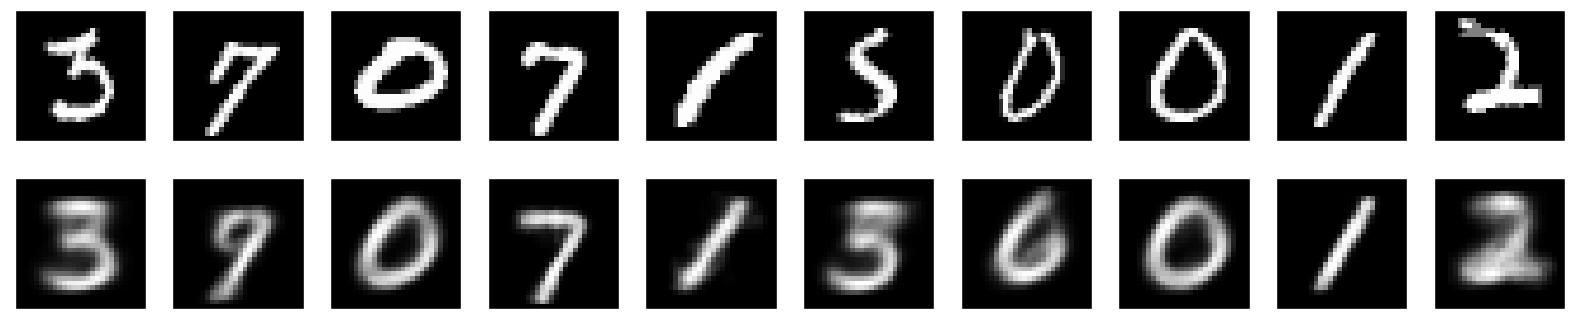

In [78]:
# plot original digit, reconstruction, and probability
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n+1):
    img_idx = np.random.randint(0,y_test.shape[0])
    print('image index: ' + str(img_idx) +
          ' normal: ' + str(y_test_binary[img_idx]) + 
          ' probability: ' + str(probs[img_idx]))
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[img_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(x_test_recons[img_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

It can be instructive to visualize what are the most normal images in our test set according to the model.

image index: 3562 normal: 1.0 probability: 0.95793164
image index: 5112 normal: 1.0 probability: 0.9579687
image index: 378 normal: 1.0 probability: 0.95725596
image index: 9345 normal: 1.0 probability: 0.9568953
image index: 9705 normal: 1.0 probability: 0.9564374
image index: 6901 normal: 1.0 probability: 0.95618004
image index: 8724 normal: 1.0 probability: 0.95624983
image index: 754 normal: 1.0 probability: 0.9552607
image index: 385 normal: 1.0 probability: 0.95462847
image index: 1897 normal: 1.0 probability: 0.954154


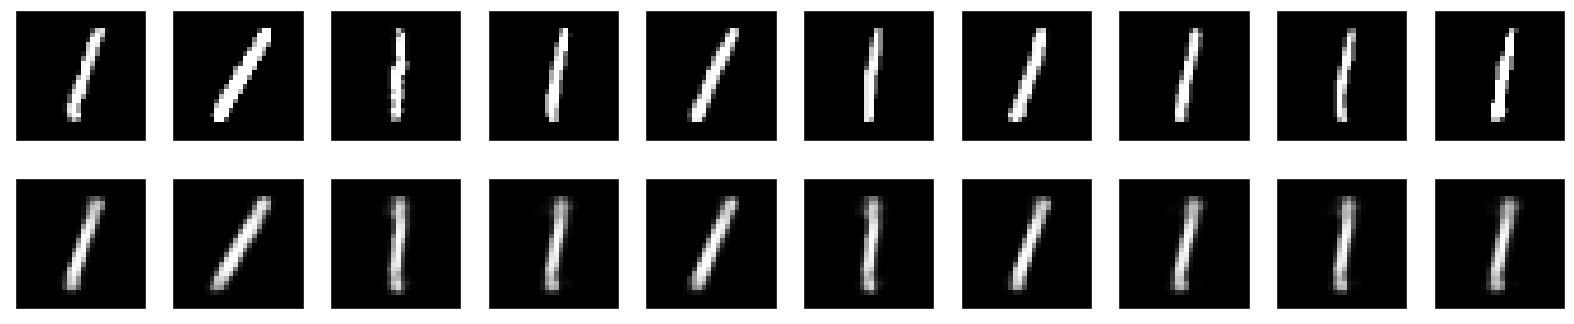

In [79]:
# plot n highest probability reconstructions
n = 10
ten_highest = np.argpartition(-probs, n)
plt.figure(figsize=(20, 4))
for i in range(1,n+1):
    img_idx = ten_highest[i-1]
    print('image index: ' + str(img_idx) +
          ' normal: ' + str(y_test_binary[img_idx]) + 
          ' probability: ' + str(probs[img_idx]))
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[img_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(x_test_recons[img_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

It's also helpful to visualize what are the most anomalous images according to our model.

image index: 9596 normal: 0.0 probability: 0.6128734
image index: 7919 normal: 0.0 probability: 0.60404694
image index: 8015 normal: 0.0 probability: 0.57827276
image index: 2802 normal: 1.0 probability: 0.60654217
image index: 2462 normal: 1.0 probability: 0.6075154
image index: 7845 normal: 0.0 probability: 0.5964495
image index: 1352 normal: 1.0 probability: 0.5603703
image index: 7871 normal: 0.0 probability: 0.61921155
image index: 9980 normal: 1.0 probability: 0.6235705
image index: 7926 normal: 0.0 probability: 0.625493


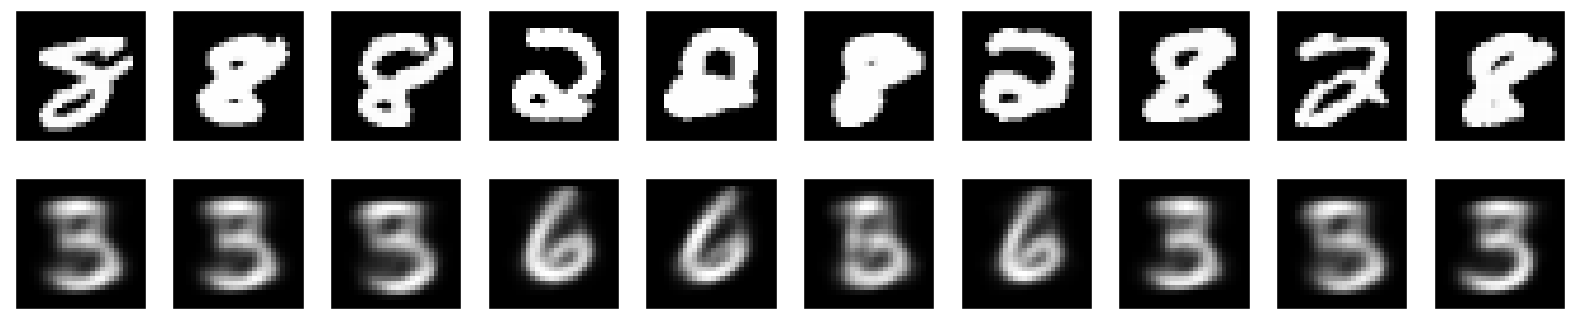

In [80]:
# plot n lowest probability reconstructions
n = 10
ten_highest = np.argpartition(probs, n)
plt.figure(figsize=(20, 4))
for i in range(1,n+1):
    img_idx = ten_highest[i-1]
    print('image index: ' + str(img_idx) +
          ' normal: ' + str(y_test_binary[img_idx]) + 
          ' probability: ' + str(probs[img_idx]))
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[img_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(x_test_recons[img_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

__Question__: what can you say about the probabilities of your most anomalous digits?

__Try This__: Change the anomalous digit and retrain the model.  Is the anomaly detection model effective for digit?

__Try This__: Retrain the VAE without removing an anomalous digit. What do you notice about the images that are found to be anomalous?

## Model Evaluation

To evaluate the effectiveness of the model, we can use a ROC curve and compute the AUC (area-under-the-curve).  A diagonal line represents the performance similar to random chance (i.e., flipping a coin).  A quickly rising ROC curve indicates a well performing model.  Similarly, an AUC of .5 means random chance and a quickly rising AUC means the model is performing well.

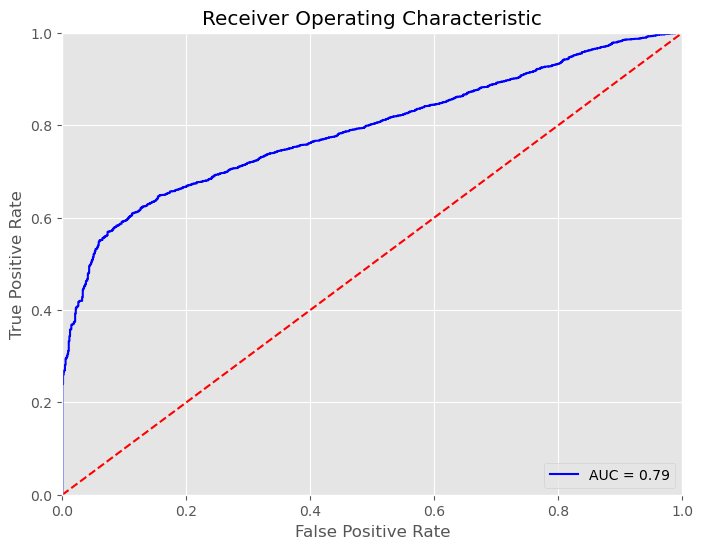

In [81]:
# compute the ROC curves
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

auc = roc_auc_score(y_test_binary, probs)
fpr, tpr, thresholds = roc_curve(y_test_binary, probs)

plt.figure(figsize=(8, 6))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

__Question__: How does the anomolous digit affect the AUC after retraining?

Since we learned the distribution underlying our data using the VAE, we can repeatedly sample the distribution to generate more data.  The more we sample, the lower variance our probability estimate will have due to averaging.

In [82]:
# compute reconstruction probabilities with lower variance. Note: this takes some time to compute.
num_samples = 100
all_probs = np.zeros((x_test.shape[0], num_samples))
for i in range(num_samples):
    
    x_test_recons = sigmoid_output.predict(x_test)
    
    probs = recon_prob(x_test_recons, x_test)

    all_probs[:, i] = probs

In [83]:
mean_probs = np.mean(all_probs, axis=1)

auc with sampling: 0.7889139337828979
auc: 0.7888226506041638


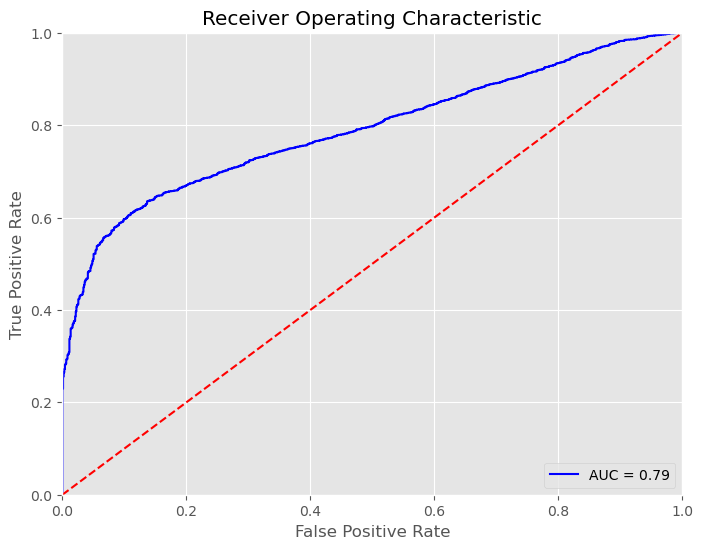

In [84]:
auc_with_sampling = roc_auc_score(y_test_binary, mean_probs)
print('auc with sampling: ' + str(auc_with_sampling))
print('auc: ' + str(auc))

fpr, tpr, thresholds = roc_curve(y_test_binary, mean_probs)

plt.figure(figsize=(8, 6))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

As you can see, for this example there is not much difference in the ROC from generating more data. 